# Linear Regression

In this notebook, we will use data from [here](http://data.princeton.edu/wws509/datasets/#salary), in which we want to see whether there's discrimination in professor salaries or not.

In [6]:
import pymc3 as pm
import pandas as pd
%matplotlib inline

The data are from [here][datasource], and have the following columns:

Independent variables:

- `sx`: the biological sex of the professor.
    - 0 for male
    - 1 for female
- `rk`: the rank of the professor.
    - 1 for assistant professor
    - 2 for associate professor
    - 3 for full professor
- `dg`: the highest degree attained
    - 0 for masters degree
    - 1 for doctorate degre
- `yd`: years since degree obtained. Essentially an 'experience' term.

Dependent variables:

- `sl`: annual salary

[datasource]: http://data.princeton.edu/wws509/datasets/#salary

Let's read in the data and do some preprocessing to make all of the data numerical.

In [66]:
# Read in the data
df = pd.read_csv('professor-salary.txt')

def replace_sx(sex):
    """
    This function codes the biological sex of the professor.
    """
    if sex == 'male':
        return 0
    elif sex == 'female':
        return 1
    
def replace_rk(rank):
    """
    This function codes the highest rank attained.
    """
    if rank == 'full':
        return 3
    elif rank == 'associate':
        return 2
    elif rank == 'assistant':
        return 1
    
def replace_dg(degree):
    """
    This function codes the highest degree earned.
    """
    if degree == 'doctorate':
        return 1
    elif degree == 'masters':
        return 0

# Perform variable numerical encoding.
df['sx'] = df['sx'].apply(lambda x: replace_sx(x))
df['rk'] = df['rk'].apply(lambda x: replace_rk(x))
df['dg'] = df['dg'].apply(lambda x: replace_dg(x))

# Preview the data
df.head()

,sx,rk,yr,dg,yd,sl
0,0,3,25,1,35,36350
1,0,3,13,1,22,35350
2,0,3,10,1,23,28200
3,1,3,7,1,27,26775
4,0,3,19,0,30,33696


## Model

We will perform linear regression on the salary data. Here's some of the modelling choices that go into this.

1. Choice of priors:
    1. Intercept: Normal distribution. Very wide.
    1. Errors: Can only be positive, therefore use HalfNormal distribution, again, very wide.
1. Choices for salary likelihood function:
    1. The salary is modelled as a linear combination of the independent variables.
    1. We assume that the salary is going to be normally distributed around the linear combination of independent variables with the same variance around the expected value.
    
That is how we get the code below.

In [68]:
import numpy as np
import theano.tensor as tt

X = df[['sx', 'rk', 'yr', 'dg', 'yd']]

with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sd=100**2)
    error = pm.HalfNormal('error', sd=100**2)

    b = pm.Normal('betas', mu=0, sd=100**2, shape=(5,1))
    sl = b[0] * df['sx'] + b[1] * df['rk'] + b[2] * df['yr'] + b[3] * df['dg'] + b[4] * df['yd'] + intercept
    sl_like = pm.Normal('likelihood', mu=sl, sd=error, observed=df['sl'])

With the recipe above, you'll have a general starting point for linear regressions (and its variants, e.g. poisson regression). The key idea, which you'll see later on, is swapping out the likelihood function.

The awesome PyMC3 developers provide also a GLM module that lets you write the above more concisely:

```python
with pm.Model() as model:
    pm.glm.glm('sl ~ sx + rk + yr + dg + yd', df)
```

However, I have given you the more verbose version, as I want you to see the code at the level of abstraction that will let you flexibly modify the model as you need it.

Borrowing shamelessly from Thomas Wiecki, we hit the Inference Button (TM) below.

In [61]:
with model:
    trace = pm.sample(draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -614.13: 100%|██████████| 200000/200000 [00:12<00:00, 15741.81it/s]
Finished [100%]: Average ELBO = -614.35
100%|██████████| 10000/10000 [00:54<00:00, 184.26it/s]


Let's visualize the traceplots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b514797b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8b4e0f1908>]], dtype=object)

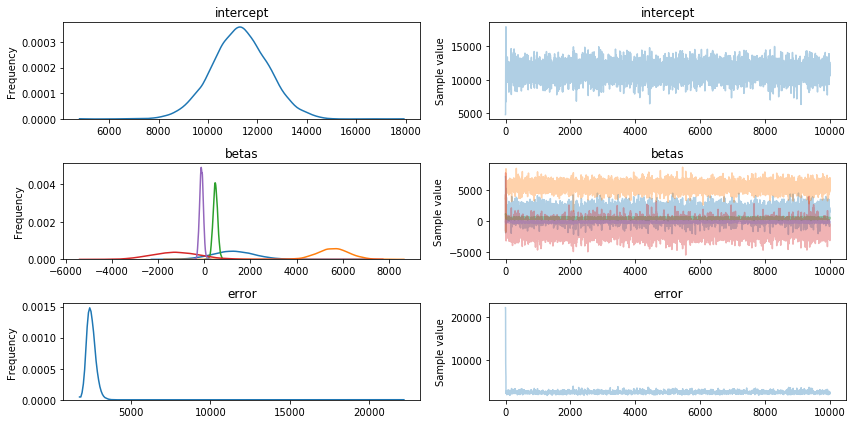

In [69]:
pm.traceplot(trace)

The traceplots give us a visual diagnostic on the convergence of the MCMC sampler. The ADVI initialization gets us pretty darn close to the places of highest likelihood. Sampling converges pretty soon after, so let's use a **burn-in** of ~1000 steps and re-check.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b4d022358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8b54f085c0>]], dtype=object)

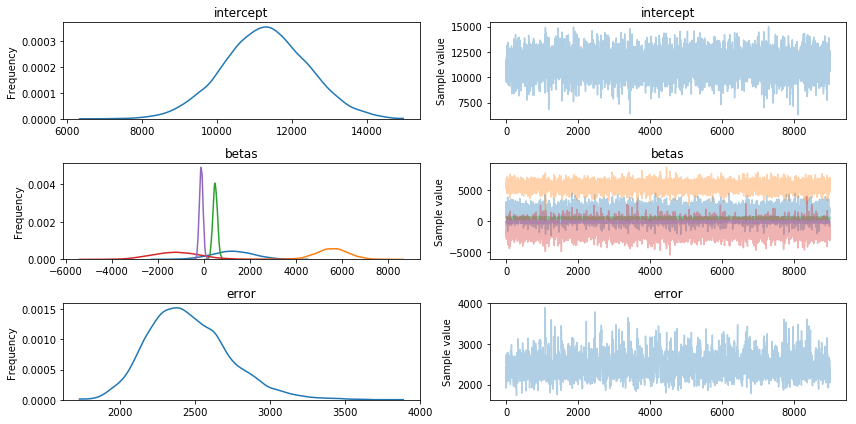

In [70]:
burnin = 1000
pm.traceplot(trace[burnin:])

Should be pretty clear - very good convergence. Let's look at a forestplot of the inferred variables.

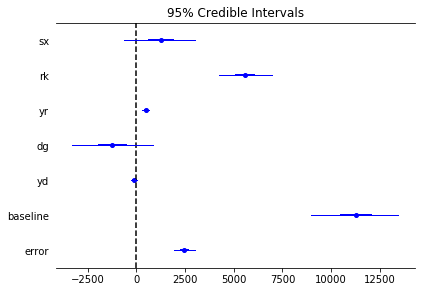

In [76]:
pm.forestplot(trace, varnames=['betas', 'intercept', 'error'], ylabels=list(X.columns)+['baseline']+['error'])

The interpretation here is as such. 

Given the data on hand, 

- a professor's baseline salary is in the range of `[8938.388, 13412.605]` dollars
- every increase in rank gives `[4229.681, 6932.360]` dollars increase in salary
- females earn `[-622.682, 3015.976]` more dollars than males
- every extra year of work earns the professor `[285.197, 671.300]` in salary
- having an advanced degree earns the professor `[-3242.757, 852.116]` in salary
- every year away from the degree earned earns the professor `[-282.419, 31.174]` in salary.

Overall, being female, attaining rank and accumulating years of work provide a net expectation of increase in salary.

See the MCMC summary statistics for how I obtained the numbers above.

In [77]:
pm.summary(trace[burnin:])


intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  11274.107        1137.632         15.784           [8938.388, 13412.605]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9022.700       10522.474      11277.379      12031.335      13515.361


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  1246.208         925.502          11.747           [-622.682, 3015.976]
  ..............................[1, :]...............................
  5553.234         697.791          10.740           [4229.681, 6932.360]
  ..............................[2, :]...............................
  482.430          98.967      